Let's solve the forward diffusion equation. The diffusion equation is:

$$
dy/dt = dy^2/dx^2 -e^{-t}(sin(\pi x) - \pi^2sin(\pi x))
$$

We will also assume the following initial condition:
    
$$
y(x,0) = sin(\pi x)
$$

and the following boundary conditions

$$
y(-1,t) = 0
$$

$$
y(1,t) = 0
$$


In this case, the true solution to the ODE is:
    
$$
y(x,t) = e^{-t}sin(\pi x)
$$

# Exploring the true solution

The best way to visualise the true solution is on a  heat map

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
device = 'cpu'

In [2]:
def y_true(x,t):
    return np.exp(-t)*np.sin(np.pi*x)

Text(0, 0.5, 't')

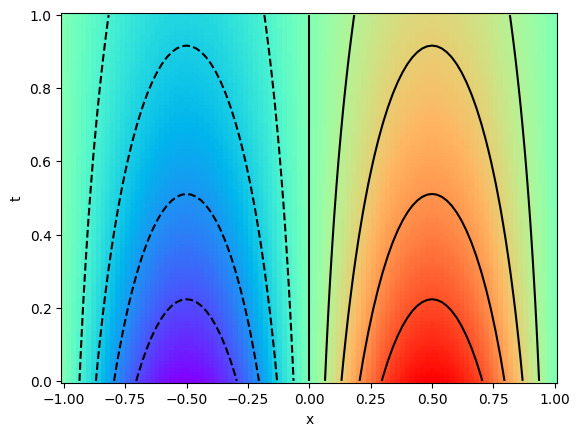

In [3]:
x = np.linspace(-1, 1, 101)
t = np.linspace(0, 1, 101)
xx,tt = np.meshgrid(x,t)
yy = y_true(xx,tt)
plt.pcolormesh(xx, tt, yy,cmap='rainbow')
plt.contour(xx, tt, yy, 10, colors='k')
plt.xlabel("x")
plt.ylabel('t')

Okay that is pretty clear. NOw let's get a Neural network to learn this, along with the boundary conditions

## Training the NN

In [4]:
import torch
from torch import nn
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.


In [5]:
def f_real(x,t):
    return torch.exp(-t)*(torch.sin(np.pi*x))

In [6]:
class FCN(nn.Module):
    def __init__(self,layers):
        super().__init__()
        self.layers = layers
        self.activation =nn.Tanh()
        self.loss_function = nn.MSELoss(reduction= 'mean')
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)]) 
        self.iter = 0
        # Option for Xiavier normal initialisation. Not necessary I don't htink
    
    def forward(self,x):
        if torch.is_tensor(x) != True:
            x = torch.from_numpy(x)
        a = x.float()
        for i in range(len(self.layers)-2):
            z = self.linears[i](a)
            a = self.activation(z)
        return self.linears[-1](a) # This one is outside of the loop, otherwise you would be applying an activation
    
    def lossBC(self,x_bc,y_bc):
        # x is the inputs (i.e. x,t pairs)
        # y is the expected output
        loss_bc = self.loss_function(self.forward(x_bc),y_bc)
        return loss_bc
    
    def lossPDE(self,x_pde):
        g = x_pde.clone()
        g.requires_grad = True # Not sure why we need to enable grad on the data??
        f = self.forward(g)
        f_x_t = autograd.grad(f,g,torch.ones([g.shape[0], 1]),retain_graph = True, create_graph = True)[0] # First derivative
        f_xx_tt = autograd.grad(f_x_t,g,torch.ones(g.shape), create_graph=True)[0]#second derivative
        f_t = f_x_t[:,[1]]
        f_xx = f_xx_tt[:,[0]]
        f = f_t - f_xx + (torch.exp(-g[:,1])*(torch.sin(np.pi*g[:,0])-np.pi**2*torch.sin(np.pi*g[:,0]))).view(-1,1)
        return self.loss_function(f,f_hat)
    
    def loss(self,x_bc,y_bc,x_pde):
        return self.lossPDE(x_pde) + self.lossBC(x_bc,y_bc)

In [7]:
class FCN1(nn.Module):
  #https://github.com/omniscientoctopus/Physics-Informed-Neural-Networks/tree/main/PyTorch/Burgers'%20Equation
    ##Neural Network
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
        self.activation = nn.Tanh()
        self.loss_function = nn.MSELoss(reduction ='mean')
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)]) 
        self.iter = 0 #For the Optimizer
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)   
    def forward(self,x):
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        a = x.float()
        for i in range(len(layers)-2):  
            z = self.linears[i](a)              
            a = self.activation(z)    
        a = self.linears[-1](a)
        return a
    #Loss BC
    def lossBC(self,x_BC,y_BC):
        loss_BC=self.loss_function(self.forward(x_BC),y_BC)
        return loss_BC
    #Loss PDE
    def lossPDE(self,x_PDE):
        g=x_PDE.clone()
        g.requires_grad=True #Enable differentiation
        f=self.forward(g)
        f_x_t = autograd.grad(f,g,torch.ones([g.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0] #first derivative
        f_xx_tt = autograd.grad(f_x_t,g,torch.ones(g.shape).to(device), create_graph=True)[0]#second derivative
        f_t=f_x_t[:,[1]]# we select the 2nd element for t (the first one is x) (Remember the input X=[x,t]) 
        f_xx=f_xx_tt[:,[0]]# we select the 1st element for x (the second one is t) (Remember the input X=[x,t]) 
        f=f_t-f_xx+ torch.exp(-g[:, 1:])* (torch.sin(np.pi * g[:, 0:1]) - np.pi ** 2 * torch.sin(np.pi * g[:, 0:1]))
        return self.loss_function(f,f_hat)

    def loss(self,x_BC,y_BC,x_PDE):
        loss_bc=self.lossBC(x_BC,y_BC)
        loss_pde=self.lossPDE(x_PDE)
        return loss_bc+loss_pde

In [8]:
# Now let's prepare the data 
x_min = -1
x_max = 1
t_min = 0
t_max = 1
total_points_x = 100
total_points_t = 100
x=torch.linspace(x_min,x_max,total_points_x).view(-1,1)
t=torch.linspace(t_min,t_max,total_points_t).view(-1,1)
X,T=torch.meshgrid(x.squeeze(1),t.squeeze(1))
y_real = f_real(X,T)

C:\anaconda3\envs\PINN\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [9]:
x_test = torch.hstack((X.transpose(1,0).flatten()[:,None],T.transpose(1,0).flatten()[:,None]))
y_test = y_real.transpose(1,0).flatten()[:,None]
lb = x_test[0,:]
ub = x_test[-1,:]

In [10]:

Nu=100 # number of boundary condition points
Nf=10000 # number of collocation points
from pyDOE import lhs         #Latin Hypercube Sampling

#Initial Condition
#Left Edge: x(x,0)=sin(x)->xmin=
left_X=torch.hstack((X[:,0][:,None],T[:,0][:,None])) # First column # The [:,None] is to give it the right dimension
left_Y=torch.sin(np.pi*left_X[:,0]).unsqueeze(1)


#Boundary Conditions
#Bottom Edge: x=min; tmin=
bottom_X=torch.hstack((X[0,:][:,None],T[0,:][:,None])) # First row # The [:,None] is to give it the right dimension
bottom_Y=torch.zeros(bottom_X.shape[0],1)
#Top Edge: x=max; 0=
top_X=torch.hstack((X[-1,:][:,None],T[-1,:][:,None])) # Last row # The [:,None] is to give it the right dimension
top_Y=torch.zeros(top_X.shape[0],1)

#Get all the training data into the same dataset
X_train=torch.vstack([left_X,bottom_X,top_X])
Y_train=torch.vstack([left_Y,bottom_Y,top_Y])

#Choose(Nu) points of our available training data:
idx=np.random.choice(X_train.shape[0],Nu,replace=False)
X_train_Nu=X_train[idx,:]
Y_train_Nu=Y_train[idx,:]

# Collocation Points (Evaluate our PDe)
#Choose(Nf) points(Latin hypercube)
X_train_Nf=lb+(ub-lb)*lhs(2,Nf) # 2 as the inputs are x and t
X_train_Nf=torch.vstack((X_train_Nf,X_train_Nu)) #Add the training poinst to the collocation points

In [11]:
print("Original shapes for X and Y:",X.shape,y_real.shape)
print("Boundary shapes for the edges:",left_X.shape,bottom_X.shape,top_X.shape)
print("Available training data:",X_train.shape,Y_train.shape)
print("Final training data:",X_train_Nu.shape,Y_train_Nu.shape)
print("Total collocation points:",X_train_Nf.shape)

Original shapes for X and Y: torch.Size([100, 100]) torch.Size([100, 100])
Boundary shapes for the edges: torch.Size([100, 2]) torch.Size([100, 2]) torch.Size([100, 2])
Available training data: torch.Size([300, 2]) torch.Size([300, 1])
Final training data: torch.Size([100, 2]) torch.Size([100, 1])
Total collocation points: torch.Size([10100, 2])


In [12]:
X_train_Nu=X_train_Nu.float()
Y_train_Nu=Y_train_Nu.float()
X_train_Nf=X_train_Nf.float()
f_hat = torch.zeros(X_train_Nf.shape[0],1)

X_test=x_test.float() # the input dataset (complete)
Y_test=y_test.float() # the real solution 

In [13]:
# Create the model
steps=20000
lr=1e-3
layers = np.array([2,32,32,1])
PINN = FCN(layers)
optimizer = torch.optim.Adam(PINN.parameters(),lr=lr,amsgrad=False)

In [14]:
# Optimise / train the model
total_loss = []
step_id =[]
for i in range(steps):
    if i ==0:
        print("Training loss --- Test Loss")
    loss = PINN.loss(X_train_Nu,Y_train_Nu,X_train_Nf)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if i%(steps/10)==0:
        with torch.no_grad():
            test_loss=PINN.lossBC(X_test,Y_test)
            total_loss.append(test_loss.detach().cpu().numpy())
            step_id.append(i)
        print(loss.detach().cpu().numpy(),'---',test_loss.detach().cpu().numpy())

Training loss --- Test Loss
17.116232 --- 0.19113983
0.0012844082 --- 0.03443243
0.00032203927 --- 0.035883196
0.00015592713 --- 0.036208533
9.162743e-05 --- 0.03619644
6.6990266e-05 --- 0.03617951
5.149233e-05 --- 0.036141276
0.0002081603 --- 0.03598822
3.2221582e-05 --- 0.036090724
2.8395876e-05 --- 0.036076598


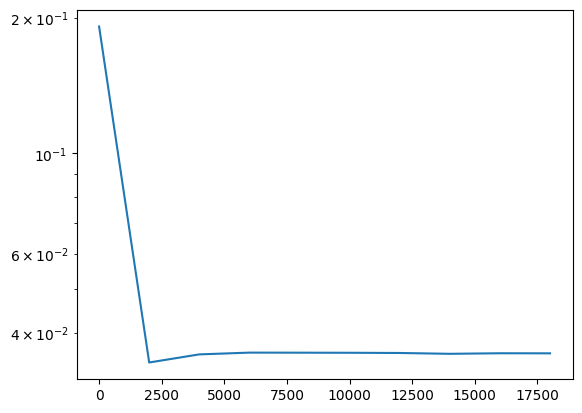

In [15]:
plt.plot(step_id, total_loss)
plt.yscale('log')

In [16]:
y1=PINN(X_test)
x1=X_test[:,0]
t1=X_test[:,1]

In [17]:
arr_x1=x1.reshape(shape=[100,100]).transpose(1,0).detach().cpu()
arr_T1=t1.reshape(shape=[100,100]).transpose(1,0).detach().cpu()
arr_y1=y1.reshape(shape=[100,100]).transpose(1,0).detach().cpu()
arr_y_test=y_test.reshape(shape=[100,100]).transpose(1,0).detach().cpu()

Text(0, 0.5, 't')

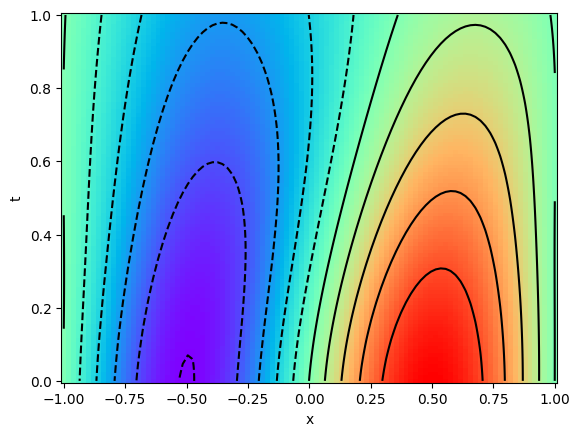

In [18]:
plt.pcolormesh(arr_x1, arr_T1, arr_y1,cmap='rainbow')
plt.contour(arr_x1, arr_T1, arr_y1, 10, colors='k')
#plt.plot(X_train_Nu.detach().numpy()[:,0],X_train_Nu.detach().numpy()[:,1],'ro')
#plt.plot(X_train_Nf.detach().numpy()[:,0],X_train_Nf.detach().numpy()[:,1],'go')
plt.xlabel("x")
plt.ylabel('t')